Christian H. Bye

Data challenge, sim3.npz (bowtie antenna). The challenge assumes a rotating antenna. Each timestep, the antenna goes through a full 2pi sweep in az and alt. A transmitter antenna is transmitting a Dirac comb for every 16th frequency channel; it's flat in ampltiude with no spectral leakage.

In [303]:
from pathlib import Path
import numpy as np
from scipy.special import sph_harm_y
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import healpy as hp
from astropy.time import Time
import hera_filters
from pygdsm import GlobalSkyModel16

%matplotlib widget

In [2]:
d = np.load("sim_v003.npz")
for k, v in d.items():
    print(k, v.shape)

freqs = d["freqs"] / 1e6  # mhz
az, alt = d["azalts"].T
data = d["data"]
times = d["times"]  # jd
tx_crds = d["tx_crds_topo"][:, 0]
tx_flux = d["tx_flux"][0]

# az and alt both go 0-2pi which is unneccsary
#data = data[:, alt <= np.pi]
#az = az[alt <= np.pi]
#alt = alt[alt <= np.pi]

# remove the last time which would mess up time averages (double counting since first == last)
print(f"Duration in JD: {times[-1] - times[0]}")
data = data[:-1]
times = times[:-1]

# mask transmitter channels
tx_freq = freqs[::16]
tx_mask = np.zeros(data.shape, dtype=bool)
tx_mask[:, :, ::16] = True
print(tx_freq)
data = np.ma.array(data, mask=tx_mask)
tx_mask_1d = tx_mask[0, 0]

freqs (1024,)
data (144, 1296, 1024)
azalts (1296, 2)
times (144,)
tx_crds_topo (3, 1)
tx_flux (1, 1024)
Duration in JD: 1.0
[ 50.          53.12805474  56.25610948  59.38416422  62.51221896
  65.6402737   68.76832845  71.89638319  75.02443793  78.15249267
  81.28054741  84.40860215  87.53665689  90.66471163  93.79276637
  96.92082111 100.04887586 103.1769306  106.30498534 109.43304008
 112.56109482 115.68914956 118.8172043  121.94525904 125.07331378
 128.20136852 131.32942326 134.45747801 137.58553275 140.71358749
 143.84164223 146.96969697 150.09775171 153.22580645 156.35386119
 159.48191593 162.60997067 165.73802542 168.86608016 171.9941349
 175.12218964 178.25024438 181.37829912 184.50635386 187.6344086
 190.76246334 193.89051808 197.01857283 200.14662757 203.27468231
 206.40273705 209.53079179 212.65884653 215.78690127 218.91495601
 222.04301075 225.17106549 228.29912023 231.42717498 234.55522972
 237.68328446 240.8113392  243.93939394 247.06744868]


In [3]:
tstart, tstop = Time([times[0], times[-1]], format="jd").to_datetime()
print(tstart, tstop)
extent = [freqs[0], freqs[-1], tstop, tstart]

def waterfall(data, log=False, vmin=None, vmax=None, aspect="auto", extent=extent, interpolation="none", cmap="plasma", title=None):
    if log:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    plt.figure()
    plt.imshow(data, aspect=aspect, extent=extent, interpolation=interpolation, cmap=cmap, norm=norm)
    plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

2024-10-17 18:00:00 2024-10-18 17:49:55.804203


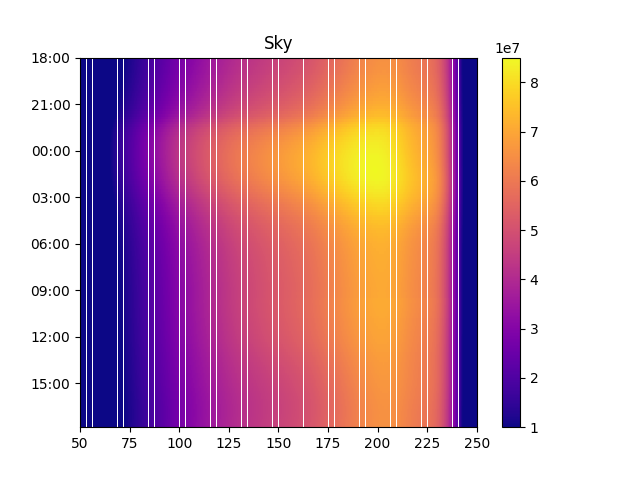

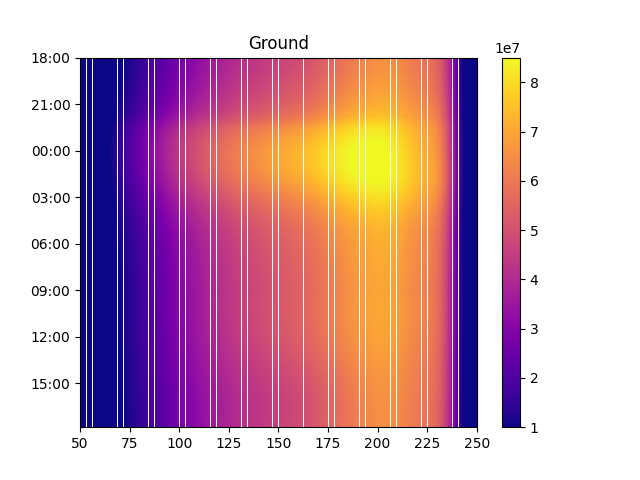

In [4]:
waterfall(data[:, 0], log=False, vmin=1e7, vmax=8.5e7, title="Sky")  # antenna pointing "up"
waterfall(data[:, -18], log=False, vmin=1e7, vmax=8.5e7, title="Ground") # antenna pointing "down"

## Beam Mapping

We fit a DPSS model to the measured data and assume that the residual contribution is the transmitter. We average over time first, which is equivalent to a joint fit at each timestep (when everything is linear).

Note that the value we get is the beam directivity times the bandpass and beam efficiency etc. It captures the full frequency dependence of the instrument. The simulation does not capture the polarization mismatch between the transmitter and the bowtie. It also assumes the bowtie beam is independent of the azimuthal rotations of the antenna.

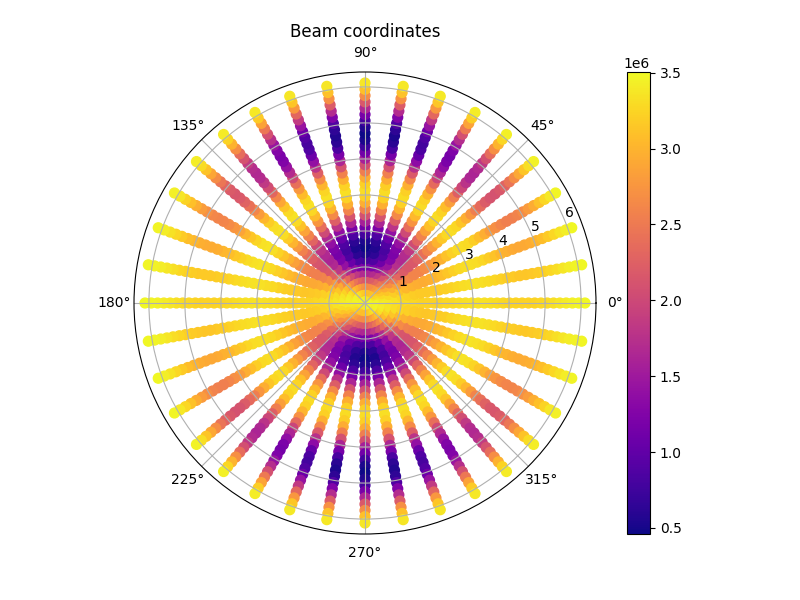

In [5]:
dtavg = data.data.mean(axis=0)  # avg in time, shape: (angle, freq)
tx_data = dtavg[:, ::16] # only tx freqs
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 6))
sc = ax.scatter(az, alt, c=tx_data[..., 0], cmap="plasma", s=50)
plt.colorbar(sc, ax=ax, label="")
ax.set_title("Beam coordinates", pad=25)
plt.show()

In [15]:
# for each rotation, we fit dpss
def fit_dpss_step(freq, spec):
    """
    freq : all frequencies in MHz (len Nfreq)
    spec : time avg data, at one rotation (len Nfreq)

    returns:
    mdl : dpss model for smooth component
    res_smooth : residuals for non-tx freqs only
    res : full residuals
    """
    weights = np.ones_like(spec)
    weights[::16] = 0  # 0 out tx freqs
    freq_Hz = freq * 1e6
    df = freq_Hz[1] - freq_Hz[0]
    filter_half_width = 1/(4*df)  # 1/2df is nyquist, make it 1/2 that to not fit comb
    mdl, res_smooth, info = hera_filters.dspec._fit_basis_1d(freq_Hz, spec, weights, [0], [filter_half_width], {"eigenval_cutoff": [1e-12]}, method="matrix", basis="dpss")
    mdl = mdl.real
    res_smooth = res_smooth.real
    res = spec - mdl
    nterms = info["amat"].shape[1]
    chi_sq = np.mean(res_smooth**2) / (freq.size - nterms)
    return mdl, res_smooth, res, chi_sq

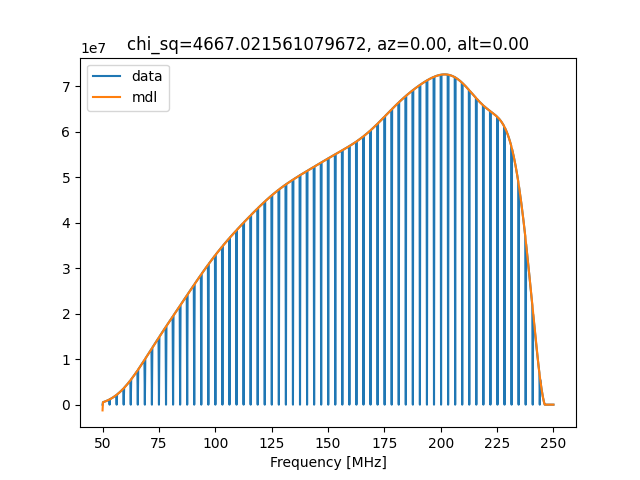

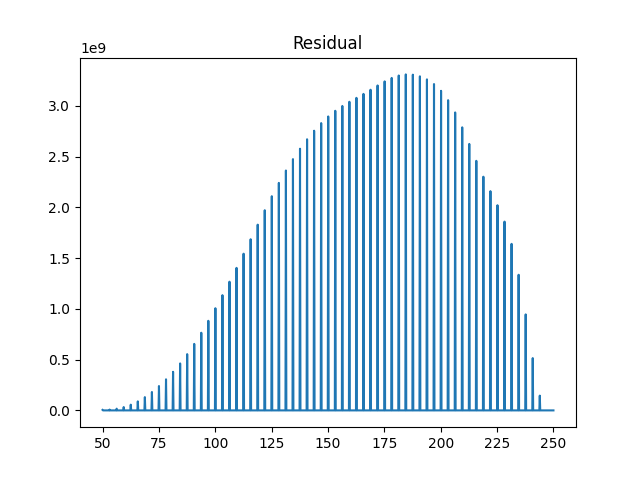

In [16]:
for rix in [0]:
    mdl, res_smooth, res, chi_sq = fit_dpss_step(freqs, dtavg[rix])
    smooth_data = dtavg[rix].copy()
    smooth_data[::16] = 0
    plt.figure()
    plt.plot(freqs, smooth_data, label="data")
    plt.plot(freqs, mdl, label="mdl")
    plt.title(f"{chi_sq=}, az={az[rix]:.2f}, alt={alt[rix]:.2f}")
    plt.legend()
    plt.xlabel("Frequency [MHz]")
    plt.show()
    plt.figure()
    plt.plot(freqs, res)
    plt.title("Residual")
    plt.show()

In [21]:
# fit each position
Nrot = az.size
Nfreq = freqs.size

fname = "tx_meas.npz"
overwrite = False
if overwrite or not Path(fname).exists():
    chi_sq = np.empty(Nrot)
    res = np.empty((Nrot, Nfreq))
    for i in range(Nrot):
        if i % 100 == 0:
            print(f"{i}/{Nrot}")
        mdl, res_smooth, res[i], chi_sq[i] = fit_dpss_step(freqs, dtavg[i])
    np.savez(fname, res=res, chi_sq=chi_sq)
else:
    npz = np.load(fname)
    res = npz["res"]
    chi_sq = npz["chi_sq"]

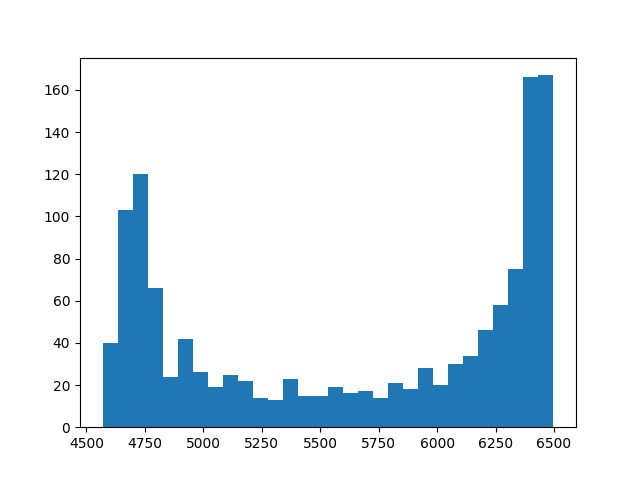

In [18]:
plt.figure()
plt.hist(chi_sq, bins=30)
plt.show()

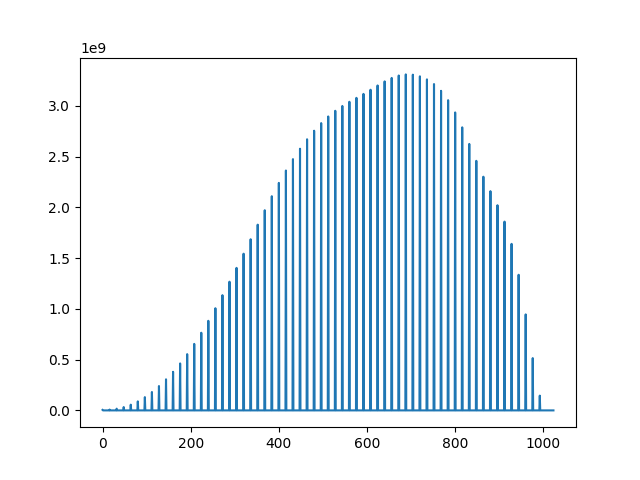

In [22]:
plt.figure()
plt.plot(res[2])
plt.show()

In [132]:
def get_unique(arr, tol=None, axis=None):
    """
    Get unique arrays up to some tolerance
    """
    arr = np.asarray(arr)
    if tol is None:
        q = arr
    else:
        q = np.rint(arr/tol).astype(np.int64)
    unique, ixs, inv, cnts = np.unique(q, axis=axis, return_index=True, return_inverse=True, return_counts=True)
    return np.take(arr, ixs, axis=axis), ixs, inv, cnts

def rod_rot(v, k, theta):
    """
    Rodrigues rotation formula.

    Rotate vector v around k by an angle theta.

    Parameters
    ----------
    v : 1d vector or stack of vectors with shape (Nvec, 3)
    k : 1d unit vector or stack of unit vectors with shape (Nvec, 3)
    theta : angle or list of angles with len Nvec
    """
    vs, ks, ts = np.broadcast_arrays(v, k, theta[..., None])
    return vs * np.cos(ts) + np.cross(ks, vs) * np.sin(ts) + ks * np.sum(ks * vs, axis=-1, keepdims=True) * (1-np.cos(ts))

def azalt_to_thetaphi(az, alt):
    """
    Convert az/alt coordinates representing platform rotations to the theta/phi in antenna frame.
    
    Note that the transmitter is below the antenna (in the direction of (0, 0, -1)). We must flip the coordinates to get the normal beam coordinates,
    since e.g. az=alt=0 deg (the home position) is actually probing the backlobe of the antenna.

    Note also that the az axis is fixed to the box, which rotates with alt. So can do alt rotation first.
    Alt rotation is around x-axis in original frame (world frame). Az rotation is round z-axis in rotated frame, call it z'.
    """
    Nrot = np.size(az)
    nhat = np.array([0, 0, -1])  # dir of tx anteenna from az=alt-0
    calt, salt = np.cos(alt), np.sin(alt)
    # rotation matrix around x
    R1 = np.zeros((Nrot, 3, 3))
    R1[:, 0, 0] = 1
    R1[:, 1, 1] = calt
    R1[:, 1, 2] = -salt
    R1[:, 2, 1] = salt
    R1[:, 2, 2] = calt    
    # rotation around z', first need z' in world frame
    zp = R1 @ np.array([0, 0, 1])
    # get rot matrix
    ex, ey, ez = np.eye(3)
    Rex = rod_rot(R1 @ ex, zp, az)
    Rey = rod_rot(R1 @ ey, zp, az)
    Rez = rod_rot(R1 @ ez, zp, az)
    Rmat = np.stack([Rex, Rey, Rez], axis=-1)  # (Nrot, 3, 3)
    Rinv = np.transpose(Rmat, (0, 2, 1))
    nrot = Rinv @ nhat
    nu, ix, inv, cnts = get_unique(nrot, tol=1e-6, axis=0)
    theta = np.arccos(nrot[..., 2])
    phi = np.arctan2(nrot[..., 1], nrot[..., 0])
    return theta, phi, ix, inv, cnts
    

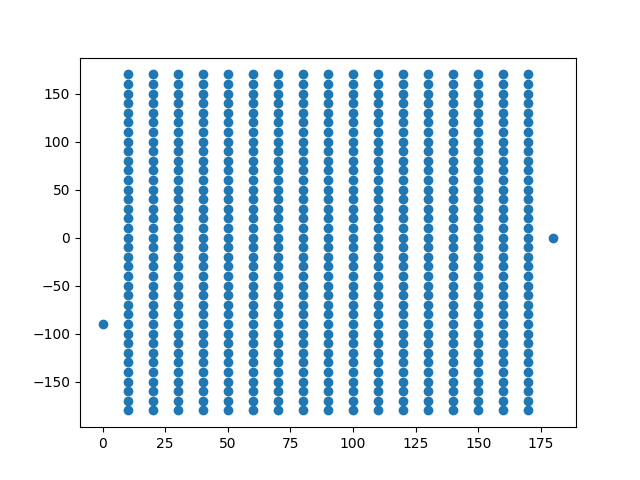

In [271]:
plt.figure()
plt.scatter(*np.rad2deg(list(zip(theta[ix], phi[ix]))).T)
plt.show()

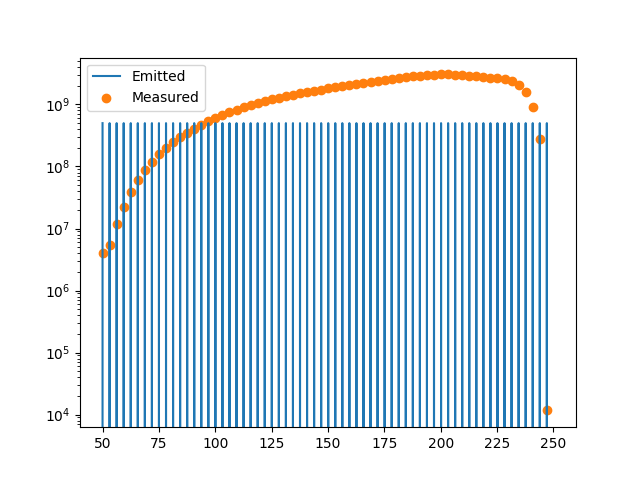

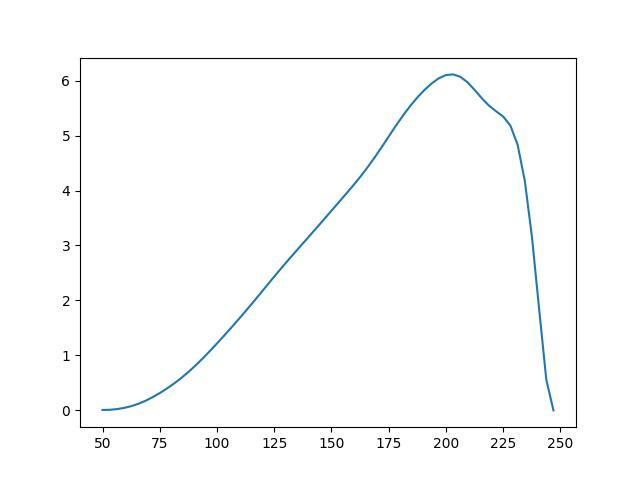

In [185]:
theta, phi, ix, inv, cnts = azalt_to_thetaphi(az, alt)

beam_raw = res[:, ::16]
beam_avg = np.zeros_like(beam_raw[ix])
np.add.at(beam_avg, inv, beam_raw)
beam_avg /= cnts[:, None]

plt.figure()
plt.plot(freqs, tx_flux, label="Emitted")
plt.scatter(tx_freq, beam_avg.mean(axis=0), label="Measured", c="C1")
plt.legend()
plt.yscale("log")
plt.show()

# the beam + system gain is measured over emitted here
# might be a factor of distance^2 too but ultimately does not matter
beam_avg /= tx_flux[None, ::16]

plt.figure()
plt.plot(tx_freq, beam_avg.mean(axis=0))
plt.show()

In [289]:
# fit spherical harmonics
def real_sph_harm_matrix(theta, phi, lmax):
    """
    Build real spherical harmonic design matrix up to lmax.

    Parameters
    ----------
    theta, phi : arrays of shape (N,)
        theta: polar angle (0..pi), phi: azimuth (0..2pi).
    lmax : int
        Maximum ell to include.

    Returns
    -------
    A : (N, Ncoeff) array
        Design matrix with real Y_{lm}(theta, phi).
    lm_list : (2, Ncoeff) array
        Array of ells (row 0) and emms (row 1)
    """
    cols = []
    ell_list = []
    emm_list = []
    ells, emms = hp.Alm.getlm(lmax)
    for i in range(ells.size):
        ell = ells[i]
        emm = emms[i]
        Y = sph_harm_y(ell, emm, theta, phi)
        if emm == 0:
            cols.append(Y.real)
            ell_list.append(ell)
            emm_list.append(emm)
        else:  # emm > 0
            # positive emm
            cols.append(np.sqrt(2) * Y.real)
            ell_list.append(ell)
            emm_list.append(emm)
            # negative emm
            cols.append(np.sqrt(2) * Y.imag)
            ell_list.append(ell)
            emm_list.append(-emm)
            
    A = np.column_stack(cols)  # (N, Ncoeff)
    lm_list = np.array([ell_list, emm_list])
    return A, lm_list

def real_to_hp_alm(coeffs_real, lmax, lm_list):
    """
    Convert real-basis SH coefficients to healpy-style complex alm.

    Parameters
    ----------
    coeffs_real : (Ncoeff,) or (Ncoeff, Nfreq)
        Coefficients in the real basis described by basis_list.
    lmax : int
    lm_list : (2, Ncoeff)
        List of corresponding l, m for each coeff.

    Returns
    -------
    alm_hp : (Nalm,) or (Nalm, Nfreq) complex
        healpy-format alm (m>=0 only).
    """
    coeffs_real = np.asarray(coeffs_real)
    squeezed = False
    if coeffs_real.ndim == 1:
        coeffs_real = coeffs_real[:, None]
        squeezed = True
    Ncoeff, Nfreq = coeffs_real.shape

    nalm = hp.Alm.getsize(lmax)
    ells, emms = hp.Alm.getlm(lmax)
    alm_hp = np.zeros((nalm, Nfreq), dtype=complex)

    i = 0
    j = 0
    while i < Ncoeff:
        ell, emm = lm_list[:, i]
        if emm == 0:
            alm_hp[j] = coeffs_real[i]
            i += 1
            j += 1
        else:
            c = coeffs_real[i]  # cos
            s = coeffs_real[i+1]  # sin
            alm_hp[j] = (c - 1j * s) / np.sqrt(2.0)
            i += 2
            j += 1

    if squeezed:
        alm_hp = alm_hp[:, 0]
    return alm_hp



def fit_sph_harm(theta, phi, beam, lmax, rcond=None, check_cond=False):
    """
    Fit a real spherical-harmonic expansion to beam(theta, phi).
    Weights by solid angle.

    Parameters
    ----------
    theta, phi : (N,) arrays
        Directions of samples.
    beam : (N, Nfreq) or (N,) array
        Beam values at those directions (can be multi-frequency).
    lmax : int
        Maximum ell to fit.
    rcond : float or None
        Passed to np.linalg.lstsq.
    check_cond : bool
        Check the condition number by doing an SVD of the weighted design matrix.

    Returns
    -------
    alm : (Ncoeff, Nfreq) array
        Fitted spherical-harmonic coefficients (real).
    """
    # Build design matrix
    A, lm_list = real_sph_harm_matrix(theta, phi, lmax)  # (N, Ncoeff)
    Ncoeff = A.shape[1]

    w = np.sin(theta)  # XXX not exactly correct but might be OK here
    # Use sqrt(w) as row weights
    W = np.sqrt(w)[:, None]
    A_w = A * W
    B_w = beam * W

    if check_cond:
        u, s, vh = np.linalg.svd(A_w, full_matrices=False)
        cAw = s[0] / s[-1]
        print(f"cond(A_w) ~ {cAw}")

    # Solve least squares for each frequency
    nfreq = beam.shape[-1]
    alm_real = np.zeros((Ncoeff, nfreq), dtype=float)
    for i in range(nfreq):
        a_i, *_ = np.linalg.lstsq(A_w, B_w[:, i], rcond=rcond)
        alm_real[:, i] = a_i

    # convert to healpy ordering
    alm = real_to_hp_alm(alm_real, lmax, lm_list)
    return alm

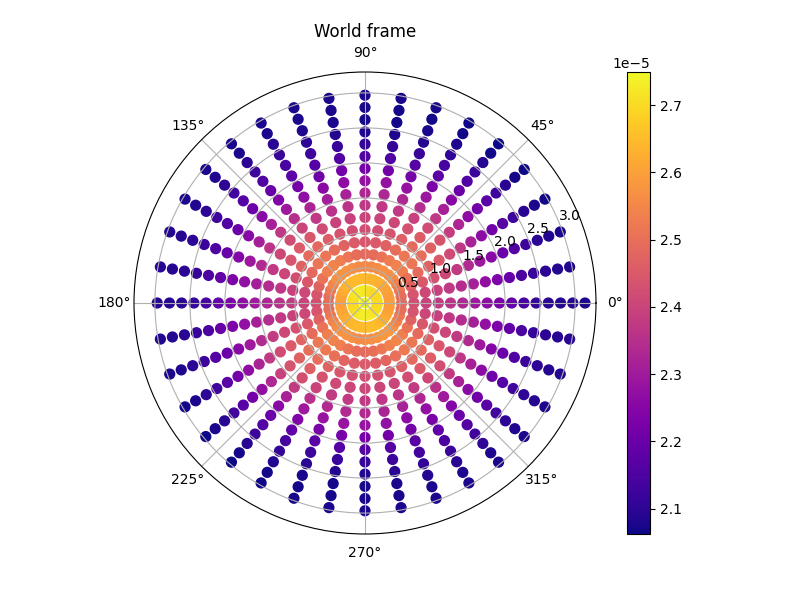

In [290]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 6))
sc = ax.scatter(phi_unique, theta_unique, c=beam_avg[:, -1], cmap="plasma", s=50)
plt.colorbar(sc, ax=ax, label="")
ax.set_title("World frame", pad=25)
plt.show()

In [368]:
theta_unique = theta[ix]
phi_unique = phi[ix]
lmax = 16
beam_alm = fit_sph_harm(theta_unique, phi_unique, beam_avg, lmax, rcond=None, check_cond=True)

cond(A_w) ~ 1.7846688861196602


nterms=12
[-0.18566391+0.j -0.14037523+0.j -0.09806007+0.j ... -3.34882545+0.j
 -3.52416094+0.j -3.69519077+0.j]


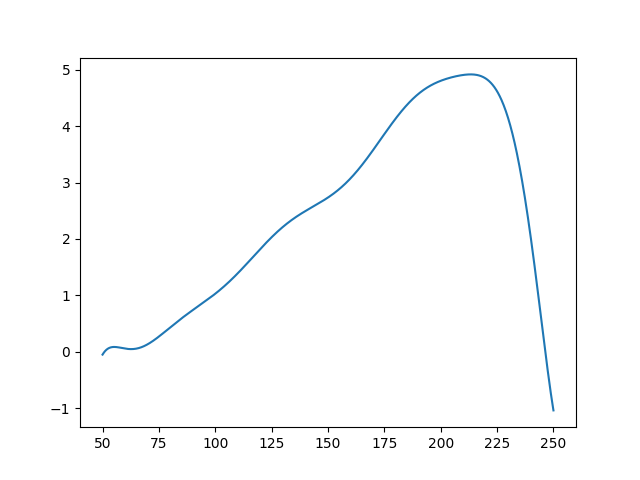

In [418]:
# fit the beam to DPSS to interpolate the frequencies, fit each alm-mode independently
freq_Hz = freqs * 1e6
df = freq_Hz[1] - freq_Hz[0]
filter_half_width = 10e-9  # 10 nanoseconds given small size of bowtie
Adpss, nterms = hera_filters.dspec.dpss_operator(freq_Hz, [0], [filter_half_width], eigenval_cutoff=[1e-12])
nterms = nterms[0]
print(f"{nterms=}")
nalm = beam_alm.shape[0]
beam = np.zeros((freqs.size, nalm), dtype=complex)
chi_sq = np.empty(nalm)
for i, mode in enumerate(beam_alm):
    coeffs, *_ = np.linalg.lstsq(Adpss[::16], mode, rcond=None)
    mdl = Adpss @ coeffs
    res = mode - mdl[::16]
    chi_sq[i] = np.mean(np.abs(res)**2)
    beam[:, i] = mdl

a00 = beam[:, 0]
print(a00)
integral_B = np.sqrt(4*np.pi) * a00
# solid-angle averaged beam:
mean_B = integral_B / (4*np.pi)

beam /= mean_B[:, None]
G_rx = mean_B.real

plt.figure()
plt.plot(freqs, G_rx)
plt.show()

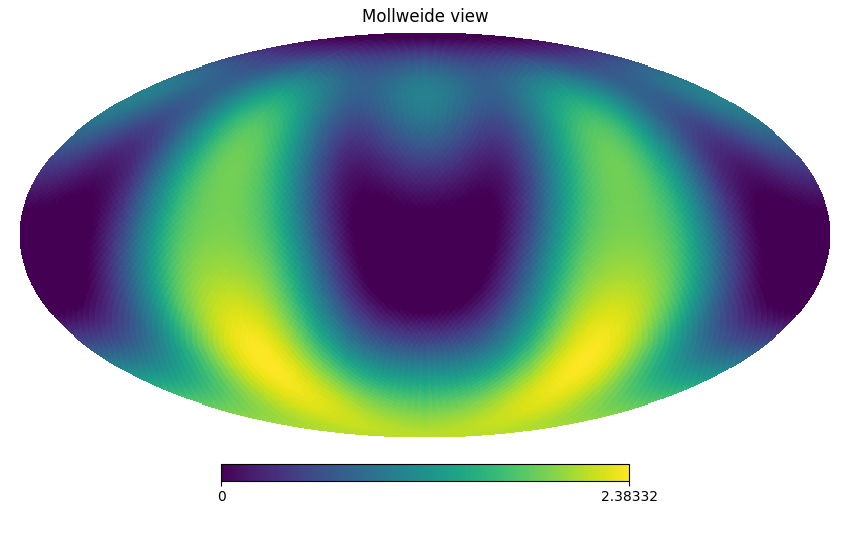

In [419]:
nside = 32
beam_hp = hp.alm2map(beam, nside, pol=False)

hp.mollview(beam_hp[90], cbar=True, min=0)
plt.show()

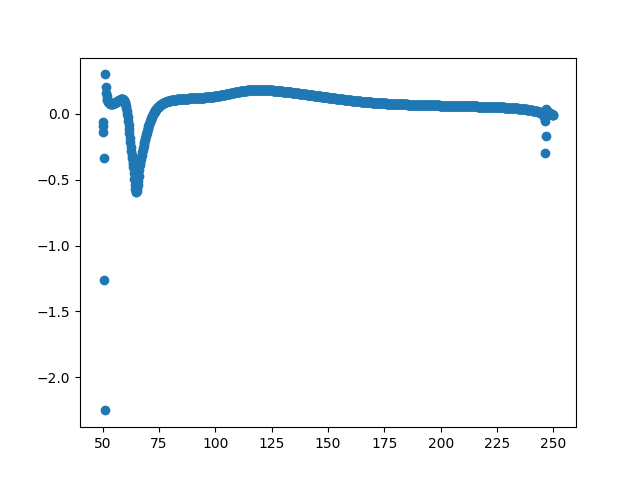

In [420]:
plt.figure()
plt.scatter(freqs, np.min(beam_hp, axis=1))
plt.show()

In [421]:
import os
os.getcwd()

'/home/christian/Documents/research/eigsep/mock_analysis/data_challenges'

## Save all raw models before further processing



## Validation of beam model

We aim to implement a blind foreground separation, but we use the GSM to validate the beam measurement and fit for ground tempeature, receiver temperature, and horizon profile.

In [305]:
gsm = GlobalSkyModel16(freq_unit="MHz", data_unit="TRJ", resolution="lo", include_cmb=True)